## math stuff

$$
\begin{equation*}
\begin{aligned}
\max_{b}      \quad & \min\left(\log\left(R^T b\right) + A^T \lambda \right) - c^T \lambda\\
\textrm{s.t.} \quad & 1^T b = 1\\
                    & b \geq 0\\
                    & \lambda \geq 0
\end{aligned}
\end{equation*}
$$

where

$$ A = \begin{pmatrix} -I \\ I \end{pmatrix}, c = \begin{pmatrix} -\pi_l \\ \pi_u \end{pmatrix} $$

## code stuff

In [66]:
%load_ext autoreload
%autoreload 2

# standard library imports
import itertools
import warnings
warnings.filterwarnings('ignore')

# third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import dump, load
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# local imports
from backtest import BacktestFramework
from kelly import DistributionalRobustKelly, NaiveKelly
from venn_abers import VennAbersCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
train_df = pd.read_csv("data/train.csv").drop(columns=["BOUT_ID", "EVENT_ID", "DATE", "BOUT_ORDINAL"])

X_train = train_df.drop(columns=["RED_WIN"])
y_train = train_df["RED_WIN"]

In [4]:
pipe = Pipeline(
    [
        ("scale", StandardScaler()),
        ("clf", LogisticRegression(penalty="l2", C=0.005994842503189409, max_iter=300, random_state=0))
    ]
)

pipe.fit(X_train, y_train)

dump(pipe, "models/logreg.joblib")

['models/logreg.joblib']

In [30]:
pipe2 = Pipeline(
    [
        ("scale", StandardScaler()),
        ("clf", LogisticRegression(penalty="l2", C=0.01, max_iter=300, random_state=0))
    ]
)

va = VennAbersCV(estimator=pipe2, inductive=False, n_splits=5, random_state=0)
va.fit(X_train.to_numpy(), y_train.to_numpy())

dump(va, "models/venn_abers_logreg.joblib")

['models/venn_abers_logreg.joblib']

In [42]:
test_df = pd.read_csv("data/test.csv").drop(columns=["DATE", "BOUT_ORDINAL", "RED_WIN"])
test_df

,BOUT_ID,EVENT_ID,FIGHTMATRIX_ELO_DIFF,FIGHTMATRIX_ELO_RATIO,FIGHTMATRIX_ELO_AVERAGE_DIFF,FIGHTMATRIX_ELO_AVERAGE_RATIO,FIGHTMATRIX_ELO_CHANGE_PREV_DIFF,FIGHTMATRIX_ELO_CHANGE_AVERAGE_DIFF,FIGHTMATRIX_OPPONENT_ELO_AVERAGE_DIFF,FIGHTMATRIX_OPPONENT_ELO_AVERAGE_RATIO,...,SHERDOG_LOSING_STREAK_MAX_DIFF,UFCSTATS_REACH_INCHES_DIFF,UFCSTATS_REACH_INCHES_RATIO,UFCSTATS_ELEVATION_METERS_AVERAGE_DIFF,UFCSTATS_ELEVATION_METERS_MAX_RATIO,UFCSTATS_PERF_BONUSES_DIFF,UFCSTATS_SIGNIFICANT_STRIKES_EXPECTED_ACCURACY_DIFF,UFCSTATS_OPPONENT_SIGNIFICANT_STRIKES_LANDED_PER_MIN_DIFF,UFCSTATS_OPPONENT_SIGNIFICANT_STRIKES_LEG_LANDED_PER_MIN_DIFF,UFCSTATS_CONTROL_TIME_SECONDS_PER_GROUND_EXCHANGE
0,3a8c0158d910546d,f5585e675af7afd4,-98,0.932831,-108.424242,0.927770,78,-33.151515,-124.151515,0.920964,...,1,3,1.043478,-41.575758,0.275678,-1,0.031311,-0.357226,0.230546,0.058333
1,7c2a02b5ea169b54,f5585e675af7afd4,135,1.088816,159.416667,1.105365,86,-30.583333,-59.583333,0.964279,...,1,-7,0.904110,-344.083333,1.000000,3,0.116362,1.499001,0.350192,-0.821429
2,3738135e4c9d8273,f5585e675af7afd4,202,1.140571,245.000000,1.177472,45,-15.444444,176.833333,1.120829,...,2,3,1.041667,-336.611111,2.116129,1,0.026362,-1.354142,-0.251690,50.791667
3,f9a4e625dffc30d4,f5585e675af7afd4,124,1.074474,18.043956,1.011203,7,15.263736,-4.340659,0.997247,...,0,4,1.062500,-164.791209,1.255370,-1,0.015678,0.399045,0.631689,-200.866667
4,8d89f3b8798f444d,f5585e675af7afd4,-37,0.977549,1.550000,1.000945,-147,10.900000,81.550000,1.049750,...,0,1,1.014925,12.550000,0.389447,0,-0.058184,-0.313613,0.565558,-61.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,2f414494f2b6f426,c398235fcaf8d71d,31,1.020516,-73.777778,0.954197,-9,1.000000,46.444444,1.032431,...,2,-6,0.916667,-166.333333,0.389447,-1,0.056250,1.137755,0.240106,102.050000
911,acc7392d48cc09a0,c398235fcaf8d71d,180,1.124052,105.000000,1.078067,-25,-51.250000,46.750000,1.031545,...,1,0,1.000000,-149.250000,1.000000,1,-0.150248,1.843259,0.153405,-44.222222
912,35f9beb94b4ef9e2,c398235fcaf8d71d,-112,0.932652,206.246154,1.132968,6,-27.069231,136.015385,1.086546,...,1,-3,0.963855,-141.307692,1.396774,5,-0.063450,-0.549254,0.000983,-74.244565
913,a7fd9da657bbce8e,c398235fcaf8d71d,83,1.051171,135.000000,1.092339,-88,-15.833333,-57.666667,0.963510,...,0,3,1.040541,-95.500000,0.472561,1,-0.019672,-3.050029,-0.085398,4.944444


In [45]:
bad_event = test_df.loc[test_df["EVENT_ID"] == "335ad945324c3a2e"]
X_test = bad_event.drop(columns=["BOUT_ID", "EVENT_ID"])

In [47]:
odds_df = pd.read_csv("data/backtest_odds.csv")
bad_event_odds = odds_df.loc[odds_df["EVENT_ID"] == "335ad945324c3a2e"]
bad_event_odds

,BOUT_ID,EVENT_ID,DATE,BOUT_ORDINAL,RED_FIGHTER_ODDS,BLUE_FIGHTER_ODDS,RED_WIN
7,4047c2e259529179,335ad945324c3a2e,2022-01-22,1,2.308333,1.640711,0.0
8,80f65ee9b6f8d63b,335ad945324c3a2e,2022-01-22,7,2.530000,1.542358,0.0
9,cddd3d4febe097f8,335ad945324c3a2e,2022-01-22,9,1.533030,2.568333,0.0
10,e786542667fdecf0,335ad945324c3a2e,2022-01-22,10,2.181667,1.693088,1.0


In [46]:
probs = pipe.predict_proba(X_test)
probs

array([[0.48302405, 0.51697595],
       [0.52281983, 0.47718017],
       [0.3961757 , 0.6038243 ],
       [0.50888673, 0.49111327]])

In [56]:
naive_kelly = NaiveKelly(
    red_probs=probs[:, 1], 
    blue_probs=probs[:, 0], 
    red_odds=bad_event_odds["RED_FIGHTER_ODDS"].to_numpy(),
    blue_odds=bad_event_odds["BLUE_FIGHTER_ODDS"].to_numpy(),
    current_bankroll=1000
)

red_wagers, blue_wagers = naive_kelly()
red_wagers, blue_wagers

(array([14.35, 13.15,  0.  ,  5.72]), array([0.  , 0.  , 1.05, 0.  ]))

In [59]:
# total wagered: 34.27
# return: 15.18
(15.18 - 34.27) / 34.27

-0.5570469798657719

In [60]:
p_prime, p0_p1 = va.predict_proba(X_test.to_numpy())
p0_p1

array([[0.50888664, 0.52017507],
       [0.47531705, 0.49431731],
       [0.58787315, 0.59342455],
       [0.43067137, 0.44286856]])

In [61]:
robust_kelly = DistributionalRobustKelly(
    p0_p1=p0_p1,
    red_odds=bad_event_odds["RED_FIGHTER_ODDS"].to_numpy(),
    blue_odds=bad_event_odds["BLUE_FIGHTER_ODDS"].to_numpy(),
    current_bankroll=1000
)

red_wagers, blue_wagers = robust_kelly()
red_wagers, blue_wagers

(array([12.39, 12.2 ,  0.  ,  0.  ]), array([0.  , 0.  , 1.68, 0.  ]))

In [62]:
np.sum(red_wagers) + np.sum(blue_wagers)

26.27

In [63]:
1.68 * 2.568333

4.31479944

In [64]:
# total wagered: 26.27
# return: 4.31
(4.31 - 26.27) / 26.27

-0.8359345260753712

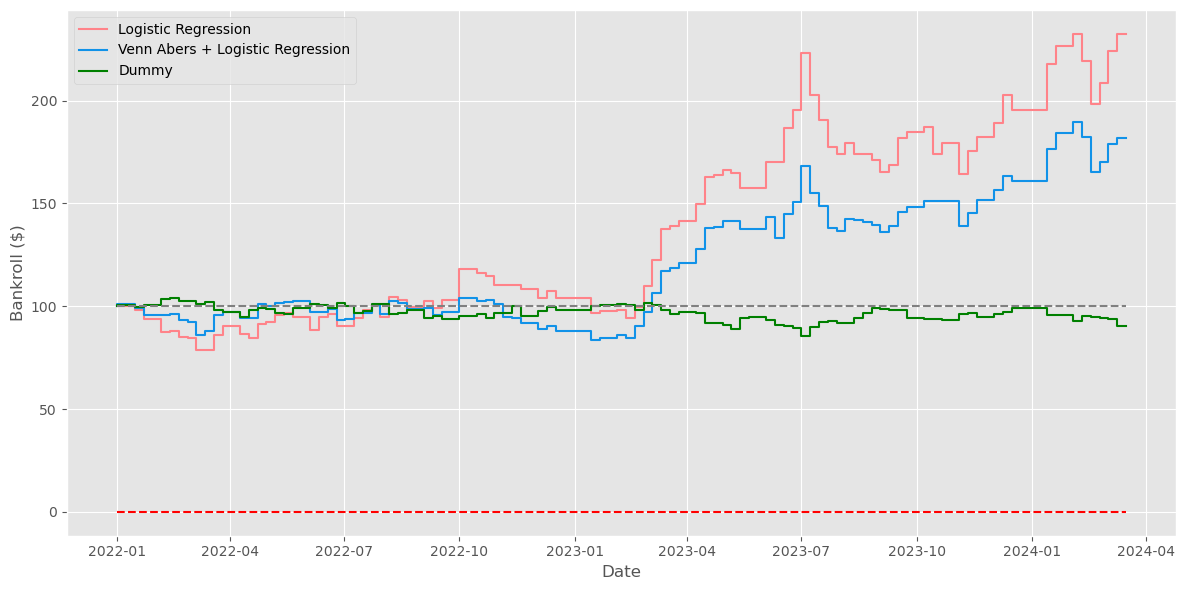

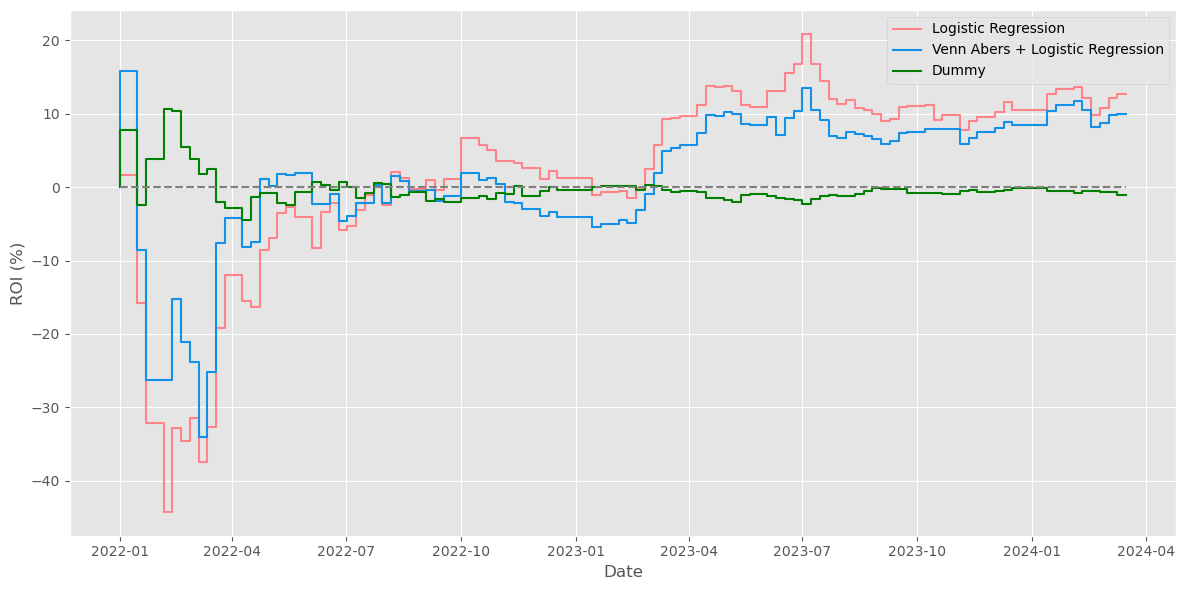

,BANKROLL_LR,BANKROLL_VA+LR,BANKROLL_DUMMY,ROI_LR,ROI_VA+LR,ROI_DUMMY
94,232.48,181.96,90.55,12.70706,9.985258,-1.068726


In [67]:
backtest = BacktestFramework()
backtest()